In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [2]:
postings = pd.read_csv("data/postings.csv")
postings = postings.dropna(subset=['listed_time'])
postings['listed_time'] = pd.to_datetime(postings['listed_time'], unit='ms', errors='coerce')
postings = postings.dropna(subset=['listed_time'])
postings = postings.drop_duplicates()

In [3]:
start_date = pd.Timestamp("2024-06-01")
end_date = pd.Timestamp("2025-04-15")
delta = end_date - start_date
delta_seconds = delta.total_seconds()
n = len(postings)
random_seconds = np.random.uniform(0, delta_seconds, n)
postings['listed_time'] = start_date + pd.to_timedelta(random_seconds, unit='s')
postings = postings.sort_values(by='listed_time')
postings['listed_time']

45152   2024-06-01 00:03:41.742148463
86925   2024-06-01 00:04:30.166889441
72601   2024-06-01 00:05:32.144804217
91910   2024-06-01 00:08:52.408424058
42301   2024-06-01 00:14:24.294847852
                     ...             
675     2025-04-14 23:52:22.787144426
83990   2025-04-14 23:52:49.189944256
87131   2025-04-14 23:53:02.555321679
69258   2025-04-14 23:55:41.753313847
79257   2025-04-14 23:56:36.212100413
Name: listed_time, Length: 123849, dtype: datetime64[ns]

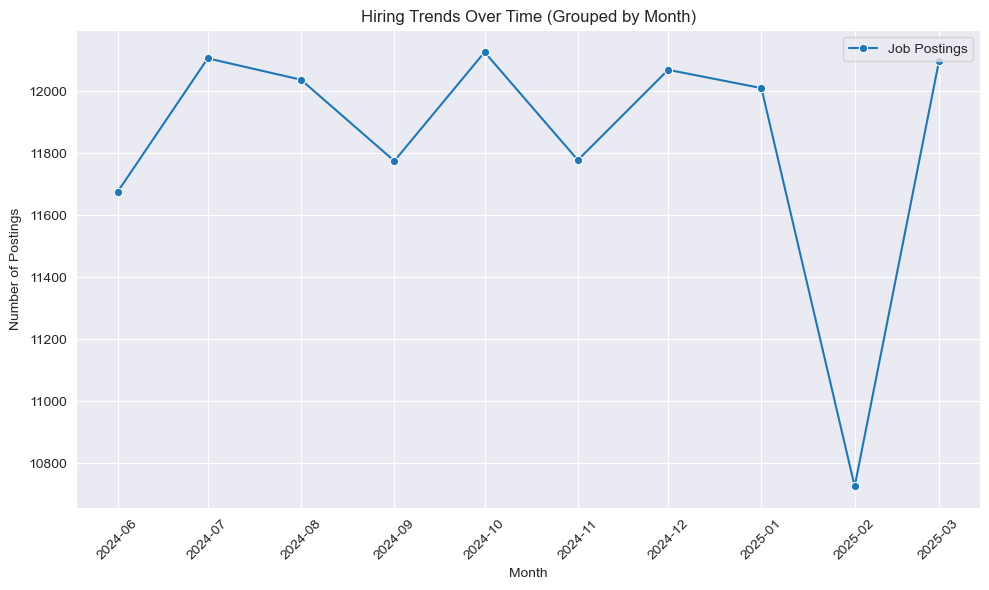

In [54]:
trend = postings.set_index('listed_time').resample('ME').size().reset_index(name='num_postings')
trend = trend.sort_values(by='listed_time')
trend['month'] = trend['listed_time'].dt.to_period('M').dt.to_timestamp()
trend = trend[trend['month'] < pd.Timestamp("2025-04-01")]
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend, x='month', y='num_postings', marker='o', label='Job Postings')
plt.title("Hiring Trends Over Time (Grouped by Month)")
plt.xlabel("Month")
plt.ylabel("Number of Postings")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

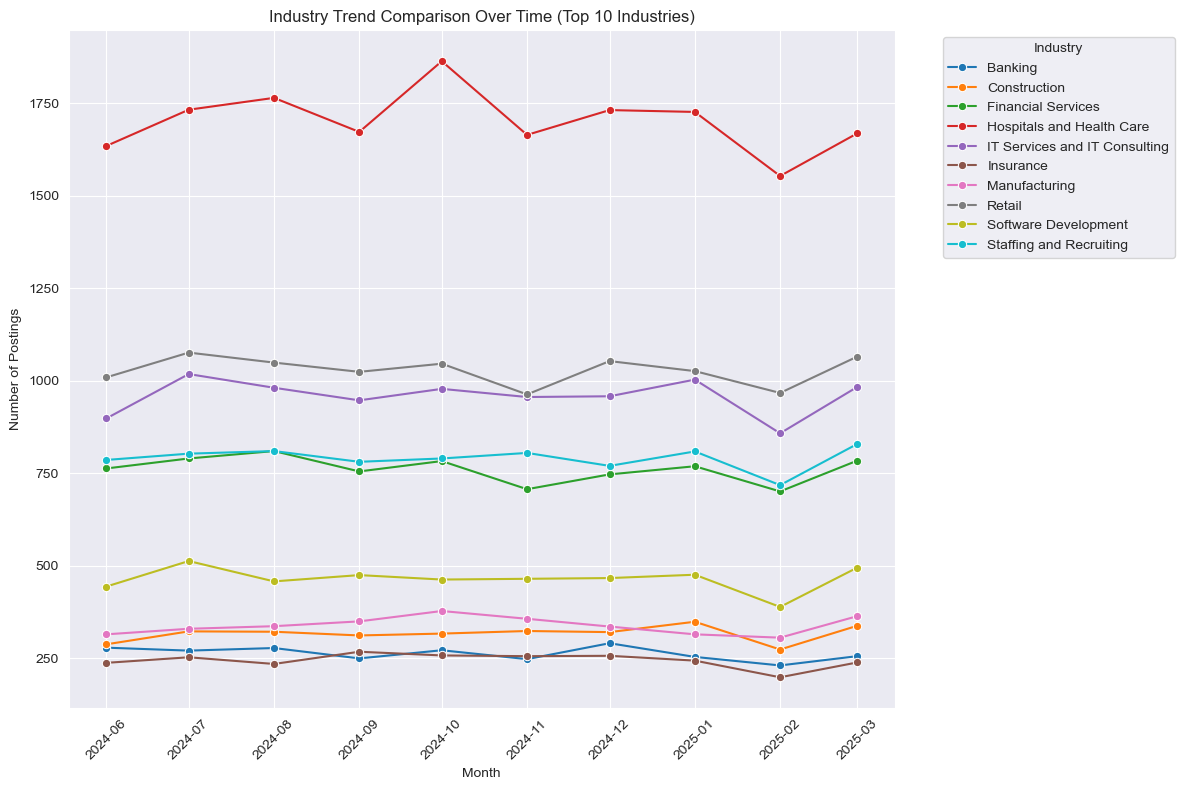

In [55]:
industries = pd.read_csv("data/mappings/industries.csv")
job_industries = pd.read_csv("data/jobs/job_industries.csv")

job_industries = job_industries.merge(postings[['job_id', 'listed_time']], on='job_id', how='left')
job_industries['listed_time'] = pd.to_datetime(job_industries['listed_time'], errors='coerce')
job_industries['year_month'] = job_industries['listed_time'].dt.to_period('M').dt.to_timestamp()

job_industries = job_industries.merge(industries, on='industry_id', how='left')
industry_trend = job_industries.groupby(['year_month', 'industry_name']).size().reset_index(name='count')
industry_trend = industry_trend[industry_trend['year_month'] < pd.Timestamp("2025-04-01")]

top_industries = industry_trend.groupby('industry_name')['count'].sum().nlargest(10).index
industry_trend_top10 = industry_trend[industry_trend['industry_name'].isin(top_industries)]

plt.figure(figsize=(12, 8))
sns.lineplot(data=industry_trend_top10, x='year_month', y='count', hue='industry_name', marker='o')
plt.title("Industry Trend Comparison Over Time (Top 10 Industries)")
plt.xlabel("Month")
plt.ylabel("Number of Postings")
plt.xticks(rotation=45)
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

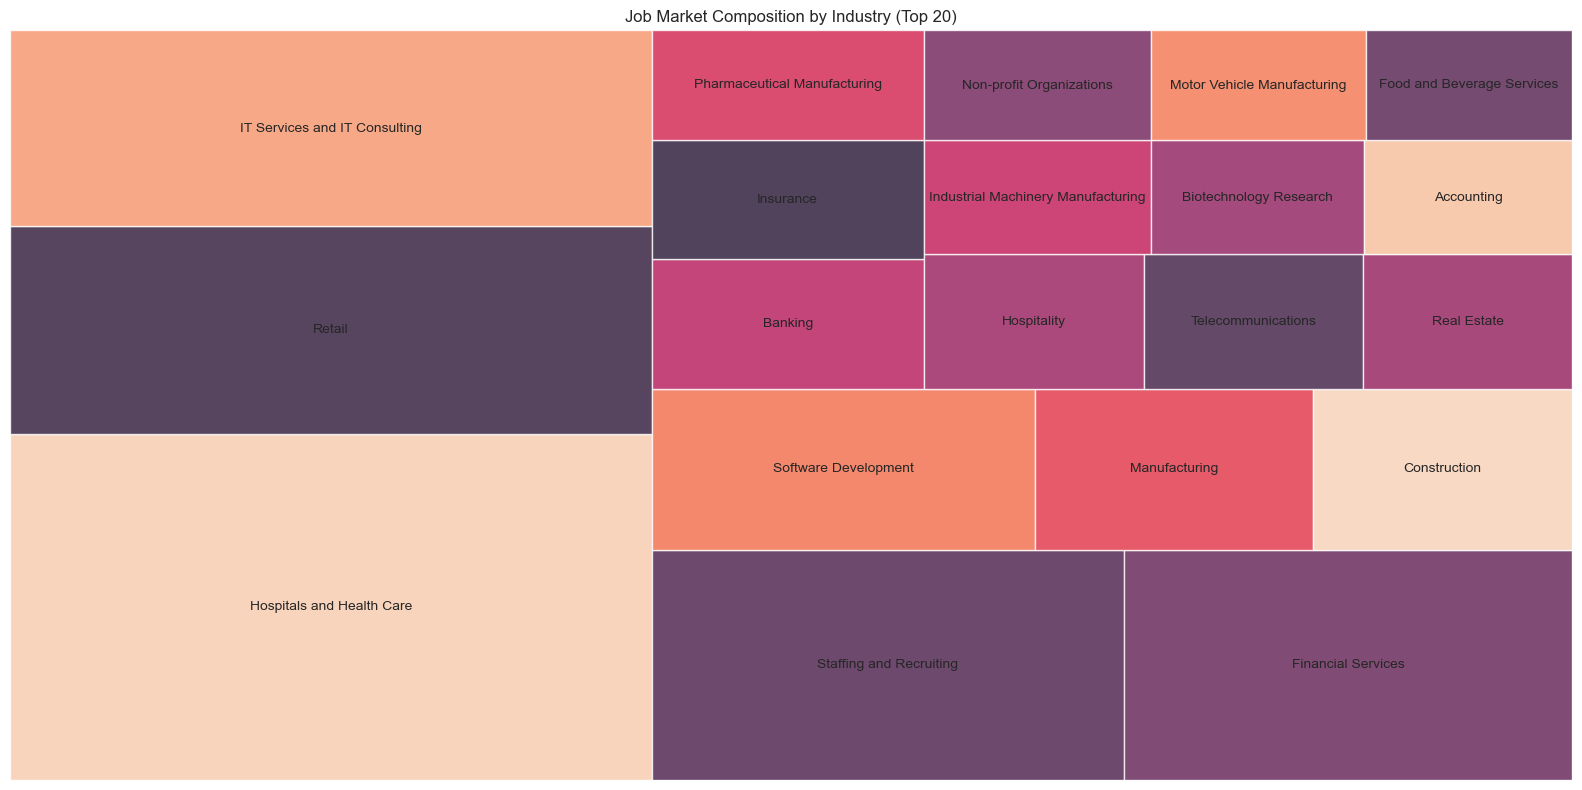

In [56]:
market_comp = job_industries.groupby('industry_name').size().reset_index(name='count')

market_comp_top = market_comp.sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(16,8))
squarify.plot(sizes=market_comp_top['count'],
              label=market_comp_top['industry_name'],
              alpha=.8)
plt.title("Job Market Composition by Industry (Top 20)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [57]:
us_indices = postings[postings['location'] == "United States"].index
to_drop = us_indices.to_series().sample(n=6000, random_state=42).index
postings = postings.drop(index=to_drop)

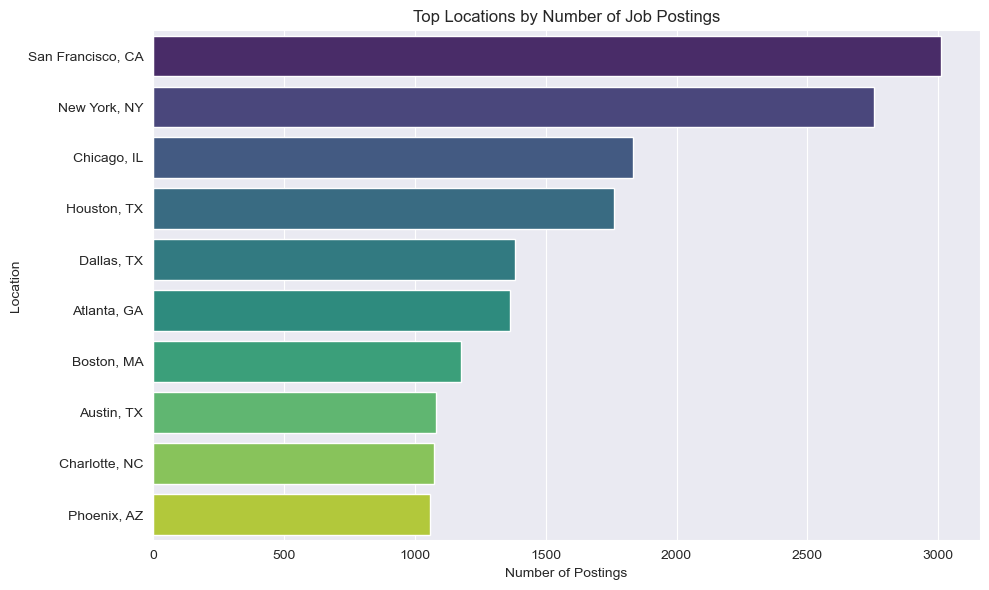

In [58]:
new_postings = postings.replace({ 'location': { "United States": "San Francisco, CA" } }).copy()
location_counts = new_postings['location'].value_counts().reset_index()
location_counts.columns = ['location', 'count']
top_locations = location_counts.head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_locations, y='location', x='count', hue='location', palette='viridis', dodge=False)
plt.title("Top Locations by Number of Job Postings")
plt.xlabel("Number of Postings")
plt.ylabel("Location")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

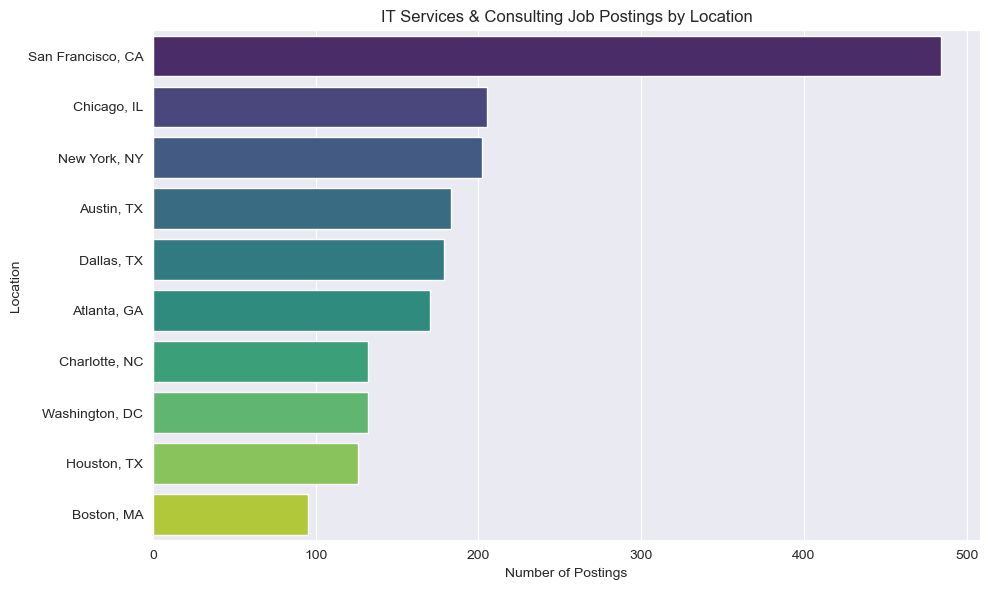

In [60]:
it_industry = job_industries[job_industries['industry_name'] == "IT Services and IT Consulting"]
it_postings = new_postings.merge(it_industry[['job_id']], on='job_id', how='inner')
it_location_counts = it_postings['location'].value_counts().reset_index()
it_location_counts.columns = ['location', 'count']
top_it_locations = it_location_counts.head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_it_locations,
    y='location',
    x='count',
    hue='location',
    palette='viridis',
    dodge=False
)
plt.title("IT Services & Consulting Job Postings by Location")
plt.xlabel("Number of Postings")
plt.ylabel("Location")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()